RunModel_IntervalTracks_to_KDE_12April2023_HDplus_iter1-FP16-10epochs-1em4 is a copy of

RunModel_IntervalTracks_to_KDE_12April2023_HDplus_iter0-FP16-10epochs-1em4

whose history is described below.

For iter1, 

   [1] use iter0 weights as starting point.
   [2] set epochs = 50
   [3] allow all weights to float


-------------------------

RunModel_IntervalTracks_to_KDE_12April2023_HDplus_iter0-FP16-10epochs-1em4


is derived from 

  RunModel_IntervalTracks_to_KDE_20July_HDplus_iter0-testing-10epochs-1em4

It starts with some weights taken from
  
    RunModel_IntervalTracks_to_KDE_12April2023_HalfDozen_iter1-FP16-500epochs-1em4_fromRepeat
    
for the fully connected layers and replaces the HalfDozen architecture with HDplus architecture that makes latentChannels output channels at layer 6 and follows that with a convolutional network followed by a single fully connected layer.

as this is the 0-th iteraction, we want to freeze the weights for the first 5 layers that have already been found from the fully connected model.

As this model trains for FP16 in the forward pass, 

  model.training_kde
  
is replaced by

  model.training_kde_FP16
  
It needs Pytorch 2.0.0 which is available in the april2023 conda environment on sleepy, which also requires
minor tweak for using pandas 2.0 in place of an earlier version. 

(as the HD training is using gpu(2), use gpu(0) for now

In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


In [2]:
import numpy as np
##  testing the np.floor and np.int_ methods as they seem to fail in a method used below
##  from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
print("np.version.version = ",np.version.version)
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
aFloor = np.floor(a)
print("a = ",a)
print("a.shape = ",a.shape)
print("aFloor = ",aFloor)
print("aFloor.shape = ",aFloor.shape)
aFloorInt = np.int_(aFloor)
print("aFloorInt = ",aFloorInt)

np.version.version =  1.23.5
a =  [-1.7 -1.5 -0.2  0.2  1.5  1.7  2. ]
a.shape =  (7,)
aFloor =  [-2. -2. -1.  0.  1.  1.  2.]
aFloor.shape =  (7,)
aFloorInt =  [-2 -2 -1  0  1  1  2]


This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [3]:
!nvidia-smi

Wed Apr 12 15:53:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   28C    P8    20W / 250W |      3MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

In [4]:
import torch
print(torch.__version__)
print(torch.cuda)

2.0.0
<module 'torch.cuda' from '/data/home/sokoloff/.conda/envs/april2023/lib/python3.9/site-packages/torch/cuda/__init__.py'>


> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch

import pandas as pd
testing = pd.__version__ 
print('testing = ',testing)
pd_major, pd_minor, pd_patch = [int(x, 10) for x in testing.split('.')]
print('pd_major, pd_minor, pd_patch  = ',pd_major, pd_minor, pd_patch)


# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

numpy.version.version =  1.23.5
testing =  2.0.0
pd_major, pd_minor, pd_patch  =  2 0 0


### Set up local parameters

In [6]:
n_epochs = 50

# Name is the output file name


##  oops!  forgot to update name of folder, so iter0 results will be written over.
##  tant pis
folder = '12April2023_FP16_HDplus_iter0_10epochs_1em4'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)

## batch_size = 64 seems to use 20 GB on 3090,
## so set batch_size = 16 so we can run on a 2080Ti
##  batch_size 16 still seems to require commenting out
##  device=device, and one epoch takes >900 seconds
##  compared to 120 seconds with batch_size = 64 on 3090
##  so try batch_size = 64 again
# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [7]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [8]:
## collectdata_kde_Ellipsoids_29Aug2021 adds zBin and zOffset to X[]
## from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
##from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
## revert to traditional collect_t2kde_data
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
## use July 2022 version of collect_t2kde_data for testing stgructure
## (and later for modifying structure of X[] and Y[])
from model.collectdata_kde_Ellipsoids_jul2022 import collect_t2kde_data


## 220714 mds 
## interval_kde_loss_Ba is derived from kde_loss_Ba, modified for 100-bin intervals
## looks like it returns average loss per bin, so costs may be directly
## comparable to original DirtyDozen
from model.interval_kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_July2022_kde import TrackIntervalsToKDE_HDplus as Model


from model.training_kde_FP16 import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [9]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [10]:
##device = "cuda"
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 NVIDIA GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [12]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

latentChannels=8

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa

## use ct<5 for getting started from HalfDozen model

ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct <0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
loss = Loss(epsilon=3e-6)

ct, child =  0    Linear(in_features=9, out_features=20, bias=True)
ct, child =  1    Linear(in_features=20, out_features=20, bias=True)
ct, child =  2    Linear(in_features=20, out_features=20, bias=True)
ct, child =  3    Linear(in_features=20, out_features=20, bias=True)
ct, child =  4    Linear(in_features=20, out_features=20, bias=True)
ct, child =  5    Linear(in_features=20, out_features=800, bias=True)
ct, child =  6    Conv1d(8, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  7    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  8    Linear(in_features=100, out_features=100, bias=True)
ct, child =  9    Dropout(p=0.15, inplace=False)
ct, child =  10    Dropout(p=0.15, inplace=False)


Let's move the model's weight matricies to the GPU:

In [13]:
model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE

## comment out reduced biases when "continuing"
##updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
##updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
##updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
##updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
##updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]


model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

output =  ML/12April2023_FP16_HDplus_iter0_10epochs_1em4
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6A.weight
index, k =   11    layer6A.bias
index, k =   12    conv1.weight
index, k =   13    conv1.bias
index, k =   14    conv2.weight
index, k =   15    conv2.bias
index, k =   16    fc1.weight
index, k =   17    fc1.bias


In [16]:

##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


##pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3_220.pyt')

##  the next model had fluctuations near the end, but the final epoch is within striking distance of the lowest cost
##pretrained_dict = torch.load('ML/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6_final.pyt')
##pretrained_dict = torch.load('ML/15July_testing_HalfDozen_first_learning_iter0_50epochs_1em4/15July_testing_HalfDozen_first_learning_iter0_50epochs_1em4_49.pyt')
##pretrained_dict = torch.load('ML/16July_testing_HalfDozen_first_learning_iter1_10epochs_1em4/16July_testing_HalfDozen_first_learning_iter1_10epochs_1em4_final.pyt')
##pretrained_dict = torch.load('ML/16July_testing_HalfDozen_first_learning_iter2_50epochs_1em4/16July_testing_HalfDozen_first_learning_iter2_50epochs_1em4_final.pyt')
##pretrained_dict = torch.load('ML/16July_testing_HalfDozen_first_learning_iter3_75epochs_1em4/16July_testing_HalfDozen_first_learning_iter3_75epochs_1em4_final.pyt')

## dictionary file name is misleading as it was produced by
## RunModel_IntervalTracks_to_KDE_12April2023_HalfDozen_iter1-FP16-500epochs-1em4_fromRepeat.ipynb
##pretrained_dict = torch.load('ML/08August_testing_HalfDozen_first_learning_iter1_500epochs_1em4_fromRepeat/08August_testing_HalfDozen_first_learning_iter1_500epochs_1em4_fromRepeat_164.pyt')
pretrained_dict = torch.load('ML/12April2023_FP16_HDplus_iter0_10epochs_1em4/12April2023_FP16_HDplus_iter0_10epochs_1em4_final.pyt')

print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)


  for pretrained_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6A.weight
index, k =   11    layer6A.bias
index, k =   12    conv1.weight
index, k =   13    conv1.bias
index, k =   14    conv2.weight
index, k =   15    conv2.bias
index, k =   16    fc1.weight
index, k =   17    fc1.bias
pretrained_dict iterated


<All keys matched successfully>

##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [17]:
## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/100_POCA_kernel_evts_210829.h5',                                  
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                                  
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
## remove commenting out 220716 as I will try to use the 3090
##                          device=device,
##  slice is used as index in feature set defined in terms of intervals
##  and there are 800K intervals in a file with 20K events
                           slice = slice(None,700000)
                           )
                            

# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
##                          device=device,
##                            slice = slice(700000,None)
                           )

Loading data...
  
kernel.shape =  (20000, 4000)
kernel.shape[0] =  20000
kernel.shape[1] =  4000
Y.shape =       (20000, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (800000, 100)
pocaMx.shape =  (20000,)


/data/home/sokoloff/.conda/envs/april2023/lib/python3.9/site-packages/awkward0/persist.py:509: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  schema = schema.tostring()


nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] =  2.8546858
minorA

len(X) =  20000
len(X_ints) = 800000
len(Xlist) =  1
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 79.4 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 0.653 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t_intervals.shape =  torch.Size([700000, 9, 150])
x_t_intervals.shape[0] =  700000
x_t_intervals.shape[1] =  9
y_t.shape =  torch.Size([20000, 12000])
y_t_intervals.shape =  torch.Size([700000, 300])
y_t_intervals.shape[0] =  700000
y_t_intervals.shape[1] =  300
Loading data...
  
kernel.shape =  (20000, 4000)
kernel.shape[0] =  20000
kernel.shape[1] =  4000
Y.shape =       (20000, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (800000, 100)
pocaMx.shape =  (20000,)
nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (200

len(X) =  20000
len(X_ints) = 800000
len(Xlist) =  1
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 77.22 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 0.4431 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t_intervals.shape =  torch.Size([800000, 9, 150])
x_t_intervals.shape[0] =  800000
x_t_intervals.shape[1] =  9
y_t.shape =  torch.Size([20000, 12000])
y_t_intervals.shape =  torch.Size([800000, 300])
y_t_intervals.shape[0] =  800000
y_t_intervals.shape[1] =  300


<IPython.core.display.Javascript object>


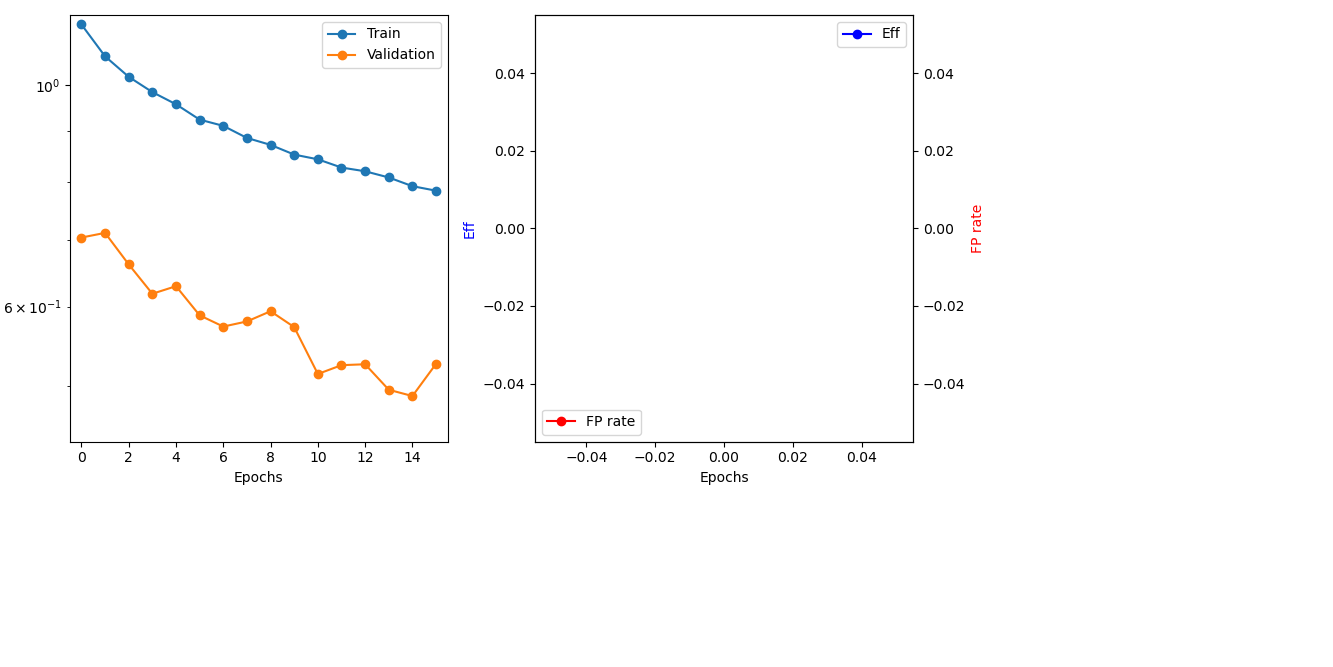

In [18]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [19]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
## for pandas version < 2.0.0 use (now obsolete) append method;
## for pandas version 2.0.0 and above use concatenation method;
## both methods are used here as some of us are using older versions
## of pandas with newer Pytorch (version 2.0 and above) and some
## are using newer versions of pandas [mds 230412] and this "upgrade"
## should fail to work for those using slightly different conda environments
    if (pd_major<2):
        results = results.append(pd.Series(result._asdict()), ignore_index=True)
    else:
    
        new_row = pd.DataFrame(result._asdict(),index=[0])
##      print('results to be concatenated = ',result)
##      print('pd.Series(result._asdict()) = ',pd.Series(result._asdict()))
##      print('results before concatenation = ',results)
        results = pd.concat([results,new_row], ignore_index=True)
##      print('results after concatenation = ',results)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 10938, val = 12500


Epochs:   0%|                                                                                       | 0/50 [00…

Number of batches: train = 10938, val = 12500


Training:   0%|                                                                                             | …

Epoch 0: train=1.15018,  val=0.703584, took 149.57 s


Training:   0%|                                                                                             | …

Epoch 1: train=1.06864,  val=0.711187, took 142.7 s


Training:   0%|                                                                                             | …

Epoch 2: train=1.01933,  val=0.661349, took 143.49 s


Training:   0%|                                                                                             | …

Epoch 3: train=0.984008,  val=0.618043, took 141.86 s


Training:   0%|                                                                                             | …

Epoch 4: train=0.956782,  val=0.628927, took 147.38 s


Training:   0%|                                                                                             | …

Epoch 5: train=0.923499,  val=0.588051, took 142.77 s


Training:   0%|                                                                                             | …

Epoch 6: train=0.910307,  val=0.572992, took 144.95 s


Training:   0%|                                                                                             | …

Epoch 7: train=0.8853,  val=0.579802, took 148.4 s


Training:   0%|                                                                                             | …

Epoch 8: train=0.871232,  val=0.593615, took 145.13 s


Training:   0%|                                                                                             | …

Epoch 9: train=0.851937,  val=0.572272, took 144.68 s


Training:   0%|                                                                                             | …

Epoch 10: train=0.842711,  val=0.513626, took 145.39 s


Training:   0%|                                                                                             | …

Epoch 11: train=0.826845,  val=0.524184, took 140.43 s


Training:   0%|                                                                                             | …

Epoch 12: train=0.819771,  val=0.52528, took 142.48 s


Training:   0%|                                                                                             | …

Epoch 13: train=0.808128,  val=0.495281, took 144.53 s


Training:   0%|                                                                                             | …

Epoch 14: train=0.792083,  val=0.488165, took 148.55 s


Training:   0%|                                                                                             | …

Epoch 15: train=0.783874,  val=0.525847, took 199.73 s


Training:   0%|                                                                                             | …

Go ahead and save the final model (even though it was also saved above):

In [20]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [21]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

In [22]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [24]:
quit()
